# VEVAR demo

In this demo, we showcase an example of utilizing VEVAR to infer brain connectivity networks and the effects of covariates.

## Load packages and functions 

In [11]:
from VEVAR_functions import *
import random
import numpy as np
import scipy.io as sio
from sklearn import preprocessing
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import csv

## Data

In [2]:
# X = time x region x subject matrix
# COV_true = P x subject matrix   
# groups = vector with group assignments 
# ps = number of covariates
# roi = number of regions
# S_g = number of subjects per group

data = sio.loadmat("data.mat")
X = data['X']
COV_true = data['Covariates']
groups = data['Groups'][0, :] 
ps = 6 
roi = 10 
S_g = [30,60] 

In [3]:
###### scale covariates ######

COV_g1 = COV_true.T[groups == 0,:]
COV_g2 = COV_true.T[groups == 1,:]
min_max_scaler = preprocessing.MinMaxScaler()
COV_g1 = 2*min_max_scaler.fit_transform(COV_g1) - 1
COV_g2 = 2*min_max_scaler.fit_transform(COV_g2) - 1
COV = np.concatenate([COV_g1,COV_g2],axis = 0)
COV = COV.T

## Run VEVAR 

In [4]:
start_time = time.time()

print("starting VEVAR")

##### input #####
# X = time x region x subject matrix
# COV = P x subject matrix   
# groups = vector with group assignments   
# L = integer with lag values to use
# pi_B = float with prior probability of edge
# pi_phi = float with prior probability of covariate selected
# sig_w = variance of slab
# ls = length scale of kernel function
# convergence_tol = when to stop algorithm
# max_iters = maximum number of iterations of algorithm before stopping

##### output #####
# q_beta_mean = subject-level edge strength
# weight_prob = probability of covariate selection
# weight_mean = mean of covariate weights
# weight_var = variance of covariate weights
# MU_phis = mean of GP for each covariate
# SIGMA_phis = covariance of GP for each covariate
# gamma_B = probability of edge inclusion
# q_B_mean = mean of group-level edge strength
# B_g_variance = variance of group-level edge strength
# Fi_mean = intercept of "slab" portion of edge strength
# Xi = noise term

q_beta_mean,weight_prob,weight_mean,weight_var,MU_phis,SIGMA_phis,gamma_B,B_g_mean,B_g_variance,Fi_mean,Xi = VEVAR(X,COV,groups,1,0.1,0.1,1,0.01,50)

run_time = time.time() - start_time

starting VEVAR
starting algorithm
finished iteration  1 0.9914944413623878
finished iteration  2 0.507497002794848
finished iteration  3 0.5027072280596572
finished iteration  4 0.37508049561079704
finished iteration  5 0.052172147385037504
finished iteration  6 0.03817415316394179
finished iteration  7 0.029937829612758593
finished iteration  8 0.023163232620658114
finished iteration  9 0.018316156593735422
finished iteration  10 0.015082154568758166
finished iteration  11 0.012395811522918021
finished iteration  12 0.011131578944835407
finished iteration  13 0.010101740822793248
finished iteration  14 0.009074761535661446


## Results

In [5]:
###### read ROI names ######
# This is an example ROI name list for fmri data
# The total number of ROI names is 90, roi = 10 is used here as an example

ROI_names = sio.loadmat("ROI_names.mat")['ROI_names']
ROI_names = [ROI_names[i].replace(' ', '') for i in range(roi)]

### Edge selection inference

First, we check the total number of selected edges for each group and then visualize the inferred networks. The red edges represent common edges in two groups.

In [6]:
inds1 = np.where(gamma_B[:,:,0] > 0.5) # index of selected edges for group 1
inds2 = np.where(gamma_B[:,:,0] > 0.5) # index of selected edges for group 2

print(f"Total number of selected edges for group 1: {(gamma_B[:,:,0] > 0.5).sum()}")
print(f"Total number of selected edges for group 1: {(gamma_B[:,:,1] > 0.5).sum()}")

# save network inference results
np.savetxt("network_group1.csv", gamma_B[:,:,0]>0.5, delimiter=",")
np.savetxt("network_group2.csv", gamma_B[:,:,1]>0.5, delimiter=",")

Total number of selected edges for group 1: 59
Total number of selected edges for group 1: 75


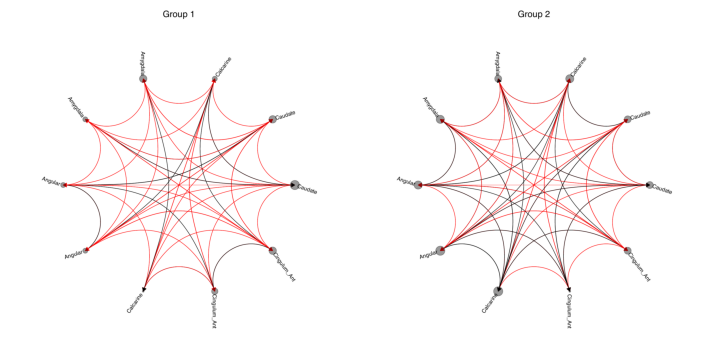

In [7]:
###### Plot networks ######
# The plots are generated using r script "Network_plot.R"

pdf_path1 = 'network_group1.pdf'
pdf_path2 = 'network_group2.pdf'

images1 = convert_from_path(pdf_path1, first_page=1, last_page=1)
images2 = convert_from_path(pdf_path2, first_page=1, last_page=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 20))  # Adjust figsize as needed

# Display the first image in the first subplot
axs[0].imshow(images1[0])
axs[0].axis('off')  # Hide axes ticks

# Display the second image in the second subplot
axs[1].imshow(images2[0])
axs[1].axis('off')  # Hide axes ticks

plt.tight_layout()
plt.show()

### Covariate selection inference

Next, we check the total number of selected covariates for each group and covariate.

In [8]:
cov_sum1 = (np.reshape(weight_prob[:,:,0],(ps,roi,roi),order = "F") > 0.5).sum((1,2))
cov_sum2 = (np.reshape(weight_prob[:,:,1],(ps,roi,roi),order = "F") > 0.5).sum((1,2))

print(f"Number of selected covariates for group 1: {cov_sum1}")
print(f"Number of selected covariates for group 1: {cov_sum2}")

Number of selected covariates for group 1: [ 6  7 10 10  9  5]
Number of selected covariates for group 1: [12 13 19 11 10  8]


We can visualize the effects of all selected covariates.

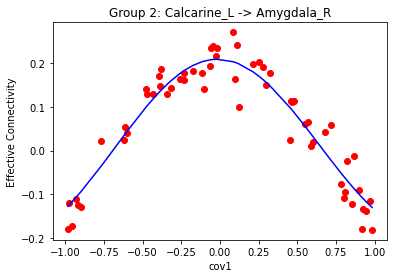

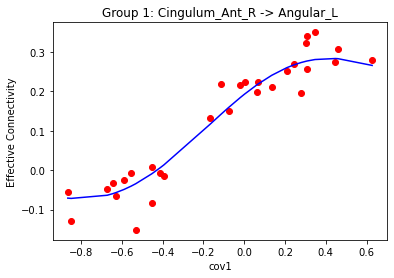

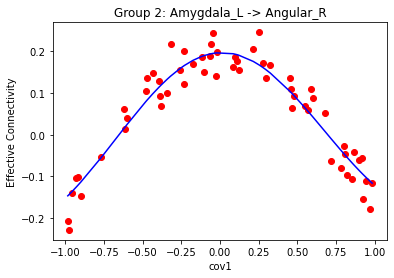

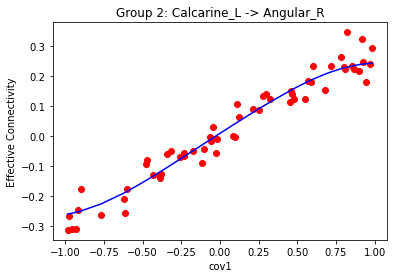

In [9]:
###### Plot covariate effects ######
inds = np.where(((np.reshape(weight_prob,(ps,roi,roi,2),order = "F")) > 0.5))
Fi = np.reshape(Fi_mean,(roi,roi,2),order = 'F')
cov_names = ['cov1', 'cov2', 'cov3', 'cov4', 'cov5', 'cov6']

# for i in range(inds[0].shape[0]): uncomment this to show all covariate effect plots
for i in range(4):
    if inds[3][i] == 0: 
        mp = np.reshape(weight_mean[:,:,0],(ps,roi,roi),order = 'F')*np.reshape(weight_prob[:,:,0],(ps,roi,roi),order = 'F')
        mu = np.reshape(MU_phis[0],(ps,roi,roi,S_g[0]),order = 'F')
        vp = np.reshape(weight_var[:,:,0],(ps,roi,roi),order = 'F')*np.reshape(weight_prob[:,:,0],(ps,roi,roi),order = 'F')
        sigs = np.reshape(SIGMA_phis[0],(ps,roi,roi,S_g[0],S_g[0]),order = 'F')
        qbm = np.reshape(q_beta_mean[:,groups == 0],(roi,roi,S_g[0]),order = "F")
        order = np.argsort(COV[inds[0][i],:S_g[0]])
        p = np.reshape(weight_prob[:,:,0],(ps,roi,roi),order = 'F')
        
        m = mu[inds[0][i],inds[1][i],inds[2][i],:][:,np.newaxis]
        v = 0
        v += (mp[inds[0][i],inds[1][i],inds[2][i]]**2)*sigs[inds[0][i],inds[1][i],inds[2][i],:,:]
        v += m.dot(m.T)*(vp[inds[0][i],inds[1][i],inds[2][i]] + (1 - p[inds[0][i],inds[1][i],inds[2][i]])*1)
        v += sigs[inds[0][i],inds[1][i],inds[2][i],:,:]*(vp[inds[0][i],inds[1][i],inds[2][i]] + (1 - p[inds[0][i],inds[1][i],inds[2][i]])*1)
        
        rmv = np.random.multivariate_normal(mu[inds[0][i],inds[1][i],inds[2][i],:]*mp[inds[0][i],inds[1][i],inds[2][i]],v,1000)
        rmv_q = np.quantile(rmv,(0.05,0.95),0)
        
        plt.plot(COV_true[inds[0][i],:S_g[0]],qbm[inds[1][i],inds[2][i],:S_g[0]],'ro')
        plt.plot(COV_true[inds[0][i],:S_g[0]][order],Fi[inds[1][i],inds[2][i],inds[3][i]] + mu[inds[0][i],inds[1][i],inds[2][i],order]*mp[inds[0][i],inds[1][i],inds[2][i]],color = 'blue')
        plt.title('Group 1: ' + ROI_names[inds[2][i]] + ' -> ' + ROI_names[inds[1][i]])
        plt.ylabel('Effective Connectivity')
        plt.xlabel(cov_names[inds[0][i]])
                
        plt.show()

    if inds[3][i] == 1: 
        mp = np.reshape(weight_mean[:,:,1],(ps,roi,roi),order = 'F')*np.reshape(weight_prob[:,:,1],(ps,roi,roi),order = 'F')
        mu = np.reshape(MU_phis[1],(ps,roi,roi,S_g[1]),order = 'F')
        vp = np.reshape(weight_var[:,:,1],(ps,roi,roi),order = 'F')*np.reshape(weight_prob[:,:,1],(ps,roi,roi),order = 'F')
        sigs = np.reshape(SIGMA_phis[1],(ps,roi,roi,S_g[1],S_g[1]),order = 'F')
        qbm = np.reshape(q_beta_mean[:,groups == 1],(roi,roi,S_g[1]),order = "F")
        order = np.argsort(COV[inds[0][i],S_g[0]:])
        p = np.reshape(weight_prob[:,:,1],(ps,roi,roi),order = 'F')
        
        m = mu[inds[0][i],inds[1][i],inds[2][i],:][:,np.newaxis]
        v = 0
        v += (mp[inds[0][i],inds[1][i],inds[2][i]]**2)*sigs[inds[0][i],inds[1][i],inds[2][i],:,:]
        v += m.dot(m.T)*(vp[inds[0][i],inds[1][i],inds[2][i]] + (1 - p[inds[0][i],inds[1][i],inds[2][i]])*1)
        v += sigs[inds[0][i],inds[1][i],inds[2][i],:,:]*(vp[inds[0][i],inds[1][i],inds[2][i]] + (1 - p[inds[0][i],inds[1][i],inds[2][i]])*1)
        
        rmv = np.random.multivariate_normal(mu[inds[0][i],inds[1][i],inds[2][i],:]*mp[inds[0][i],inds[1][i],inds[2][i]],v,1000)
        rmv_q = np.quantile(rmv,(0.05,0.95),0)
        
        plt.plot(COV_true[inds[0][i],S_g[0]:],qbm[inds[1][i],inds[2][i],:],'ro')
        plt.plot(COV_true[inds[0][i],S_g[0]:][order],Fi[inds[1][i],inds[2][i],inds[3][i]] + mu[inds[0][i],inds[1][i],inds[2][i],order]*mp[inds[0][i],inds[1][i],inds[2][i]],color = 'blue')
        plt.title('Group 2: ' + ROI_names[inds[2][i]] + ' -> ' + ROI_names[inds[1][i]])
        plt.ylabel('Effective Connectivity')
        plt.xlabel(cov_names[inds[0][i]])
                
        plt.show()

Additional results, including edge and covariate selection along with the estimated mean of effective connectivity, can be saved in a CSV file.

In [12]:
edges = (gamma_B > 0.5) *1
edges_shared = ((gamma_B[:,:,0] > 0.5) & (gamma_B[:,:,1] > 0.5))*1
covariate_edges = (np.reshape(weight_prob,(ps,roi,roi,2),order = 'F') > 0.5)*1
covariate_edges_shared = (np.reshape(((weight_prob[:,:,0] > 0.5) & (weight_prob[:,:,1] > 0.5)),(ps,roi,roi),order = 'F') > 0.5)*1
q_beta_reshape = np.reshape(q_beta_mean,(roi,roi,np.sum(S_g)),order = 'F')
Fi_mean = np.reshape(Fi_mean,(roi,roi,2),order = "F")

cols = np.arange(6)

lst = []
lst += ['ROI_OUT']
lst += ['ROI_IN']
lst += ['Group1_INDICATOR']
lst += ['Group1_' + i for i in cov_names]
lst += ['Group1_EC_means']
lst += ['Group2_INDICATOR']
lst += ['Group2_' + i for i in cov_names]
lst += ['Group2_EC_means']
lst += ['SHARED_INDICATOR']
lst += ['SHARED_' + i for i in cov_names]


with open('Results.csv','w') as f: 
    writer = csv.writer(f)
    writer.writerow(lst)
f.close()

for i in range(roi):
    for j in range(roi):
        lst = []
        lst += [ROI_names[j]]
        lst += [ROI_names[i]]
        
        lst += [edges[i,j,0]]
        lst += covariate_edges[cols,i,j,0].tolist()
        lst += [q_beta_reshape[i,j,:S_g[0]].mean()]
        
        lst += [edges[i,j,1]]
        lst += covariate_edges[cols,i,j,1].tolist()
        lst += [q_beta_reshape[i,j,S_g[0]:].mean()]
        
        lst += [edges_shared[i,j]]
        lst += covariate_edges_shared[cols,i,j].tolist()
        
        with open('Results.csv','a') as f: 
            writer = csv.writer(f)
            writer.writerow(lst)
f.close()